# Neural Network Model Fitting & Tuning Setup
In order to begin fitting a neural network model, we first clean the dataset and apply onehot encoding.

In the interest of minimising computational cost, for the majority of the tuning phase, we will perform model training on a 20% sample of our dataset (10,000 values or 50,000).

We then take 80% of the 20% sample and use this as our training set, and reserve the remaining 20% to validate our data. This is done to check that our model generalises well and is not overfitting.

In [66]:
import warnings
warnings.filterwarnings("ignore")

import numpy as np
import pandas as pd
import io
import requests

import pathlib
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

import scipy

from kerastuner.tuners import RandomSearch, BayesianOptimization

pd.set_option('display.max_columns', None) 

###
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline 
%config InlineBackend.figure_format = 'retina'
plt.style.use("ggplot")
###

In [2]:
diamond_df = pd.read_csv("diamonds.csv")

In [3]:
# Get indexes for which x, y, z < 0 or y, z > 30
incorrect_value_indexes = diamond_df[
    (diamond_df["x"] < 1) | 
    (diamond_df["y"] > 30) | 
    (diamond_df["y"] < 1) | 
    (diamond_df["z"] > 30) | 
    (diamond_df["z"] < 1)].index

# Delete these row indexes from dataFrame
df = diamond_df.drop(incorrect_value_indexes)

In [4]:
df_onehot = pd.get_dummies(df)

In [5]:
# normalisation - min max
normalized_df=(df_onehot-df_onehot.min())/(df_onehot.max()-df_onehot.min())

In [90]:
sample_df = normalized_df.sample(frac=0.1, random_state=0)
x = sample_df
y = x.pop("price")

In [91]:
from sklearn.model_selection import train_test_split
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.2, random_state=0)

In [109]:
x_train.shape

(4313, 26)

## Activation function tuning
The hyperparameters we will attempt to tune are:
1. Activation function
2. Optimizer
3. Network dimensions (number of layers and neurons per layer)
4. Batch size
5. Epoch

We start with the activation function hyperparameter as we suspect this may heavily affect the performance of the model. We then follow this with the optimizer for the same reason.

As we are solving a regression problem, we set the output layer to a single neuron with a linear activation function.

In order to test the activation function, we must set initial static values for the other variables. We have chosen not to test all variables together in combination at the same time due to restrictions in computational power (the limitations of this approach will be discussed further below). 
* We will use a default loss function of MSE (mean squared error) for our regression model
* We will use the Adam optimizer to begin with as it is a popular algorithm, and is regarded as being fairly robust. We will not be tuning the learning rate manually.
* We will also use 64 neurons per layer to begin with and we will be testing with 5 epochs (We have chosen this value in the interest of minimising computational cost, however, this may be optimizing for hyperparameters that lead to the fastest initial improvement as opposed to finding hyperparameters leading to the best overall results)

#### Custom testing function
We define a function that takes in a list of activation function types as well as a list of neural network layers to test the activation types against.
* we are testing against multiple neural network layers to determine whether certain activation functions interact differently depending on the amount of network layers.

The function then loops through every combination of activation types vs number of layers and creates a unique NN model. It then trains the respective model with the specified amount of epochs and returns the validatin loss metric (MSE).

Once all models have been trained and assessed, a results dataframe containing the model details and the respective val_MSE is returned for us to plot and analyse.

In [92]:
def test_activation_types(x_train, x_test, y_train, y_test, activation_types, test_layers, epochs):
    activation_types_results = pd.DataFrame(columns=['activation_function', 'layers', 'val_mse'])
    
    for activation_type in activation_types:
        for num_layers in test_layers:
            # Run full model with activation type and num layer combo, then append results to dataframe
            model = keras.Sequential()
            model.add(layers.Dense(64, activation=activation_type, input_shape = [len(x_train.keys())])) # set initial input shape of model
            for layer in range(1, num_layers):
                model.add(layers.Dense(64, activation=activation_type))
            model.add(layers.Dense(1, activation='linear'))
            model.compile(optimizer=keras.optimizers.Adam(),
                          loss='mean_squared_error',
                          metrics=['mean_squared_error'])
            
            #print(f"\n\n///////////////{num_layers}x {activation_type}/////////////////") # to check we are building the right model
            #print(model.summary())
            
            temporary_history = model.fit(x_train,
                                          y_train,
                                          epochs=epochs,
                                          verbose=0,
                                          validation_data=(x_test, y_test))
            extracted_hist = pd.DataFrame(temporary_history.history)
            extracted_hist['epoch'] = temporary_history.epoch
            #print(f"~~~~~~~~~~~~~~~~~ START: {extracted_hist['val_loss'].iloc[0]} END: {extracted_hist['val_loss'].iloc[-1]}")
            
            activation_types_results = activation_types_results.append({
                'activation_function': activation_type,
                'layers': num_layers,
                'val_mse': extracted_hist['val_loss'].iloc[-1]
            },
                ignore_index=True)
            
    return activation_types_results          
            
            

In [97]:
activation_types = ["Softmax", "ELU", "relu", "PReLU", "linear", "sigmoid"]
test_layers = [2, 3, 4, 5, 6, 7, 8]
epochs = 5

activation_types_results = test_activation_types(x_train, x_test, y_train, y_test, activation_types, test_layers, epochs)



///////////////2x Softmax/////////////////
Model: "sequential_75"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_300 (Dense)            (None, 64)                1728      
_________________________________________________________________
dense_301 (Dense)            (None, 64)                4160      
_________________________________________________________________
dense_302 (Dense)            (None, 1)                 65        
Total params: 5,953
Trainable params: 5,953
Non-trainable params: 0
_________________________________________________________________
None
~~~~~~~~~~~~~~~~~ START: 0.04304972663521767 END: 0.019475510343909264


///////////////3x Softmax/////////////////
Model: "sequential_76"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_303 (Dense)            (None, 64)                1728 

~~~~~~~~~~~~~~~~~ START: 0.04312431067228317 END: 0.0432705357670784


///////////////2x ELU/////////////////
Model: "sequential_82"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_342 (Dense)            (None, 64)                1728      
_________________________________________________________________
dense_343 (Dense)            (None, 64)                4160      
_________________________________________________________________
dense_344 (Dense)            (None, 1)                 65        
Total params: 5,953
Trainable params: 5,953
Non-trainable params: 0
_________________________________________________________________
None
~~~~~~~~~~~~~~~~~ START: 0.007332413457334042 END: 0.0052203526720404625


///////////////3x ELU/////////////////
Model: "sequential_83"
_________________________________________________________________
Layer (type)                 Output Shape              Param # 

~~~~~~~~~~~~~~~~~ START: 0.003925480879843235 END: 0.0018408681498840451


///////////////2x relu/////////////////
Model: "sequential_89"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_384 (Dense)            (None, 64)                1728      
_________________________________________________________________
dense_385 (Dense)            (None, 64)                4160      
_________________________________________________________________
dense_386 (Dense)            (None, 1)                 65        
Total params: 5,953
Trainable params: 5,953
Non-trainable params: 0
_________________________________________________________________
None
~~~~~~~~~~~~~~~~~ START: 0.005440687760710716 END: 0.0019115235190838575


///////////////3x relu/////////////////
Model: "sequential_90"
_________________________________________________________________
Layer (type)                 Output Shape              Pa

~~~~~~~~~~~~~~~~~ START: 0.002980463206768036 END: 0.0020807976834475994


///////////////2x PReLU/////////////////
Model: "sequential_96"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_426 (Dense)            (None, 64)                1792      
_________________________________________________________________
dense_427 (Dense)            (None, 64)                4224      
_________________________________________________________________
dense_428 (Dense)            (None, 1)                 65        
Total params: 6,081
Trainable params: 6,081
Non-trainable params: 0
_________________________________________________________________
None
~~~~~~~~~~~~~~~~~ START: 0.01048783678561449 END: 0.0023206479381769896


///////////////3x PReLU/////////////////
Model: "sequential_97"
_________________________________________________________________
Layer (type)                 Output Shape              P

~~~~~~~~~~~~~~~~~ START: 0.0031364159658551216 END: 0.002179898554459214


///////////////2x linear/////////////////
Model: "sequential_103"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_468 (Dense)            (None, 64)                1728      
_________________________________________________________________
dense_469 (Dense)            (None, 64)                4160      
_________________________________________________________________
dense_470 (Dense)            (None, 1)                 65        
Total params: 5,953
Trainable params: 5,953
Non-trainable params: 0
_________________________________________________________________
None
~~~~~~~~~~~~~~~~~ START: 0.006053967867046595 END: 0.00590604217723012


///////////////3x linear/////////////////
Model: "sequential_104"
_________________________________________________________________
Layer (type)                 Output Shape            

~~~~~~~~~~~~~~~~~ START: 0.006578047759830952 END: 0.004939052276313305


///////////////2x sigmoid/////////////////
Model: "sequential_110"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_510 (Dense)            (None, 64)                1728      
_________________________________________________________________
dense_511 (Dense)            (None, 64)                4160      
_________________________________________________________________
dense_512 (Dense)            (None, 1)                 65        
Total params: 5,953
Trainable params: 5,953
Non-trainable params: 0
_________________________________________________________________
None
~~~~~~~~~~~~~~~~~ START: 0.03731600567698479 END: 0.008017173036932945


///////////////3x sigmoid/////////////////
Model: "sequential_111"
_________________________________________________________________
Layer (type)                 Output Shape           

~~~~~~~~~~~~~~~~~ START: 0.044033411890268326 END: 0.004201936069875956


In [98]:
activation_types_results.head()

,activation_function,layers,val_mse
0,Softmax,2,0.019476
1,Softmax,3,0.043205
2,Softmax,4,0.043136
3,Softmax,5,0.043179
4,Softmax,6,0.043280


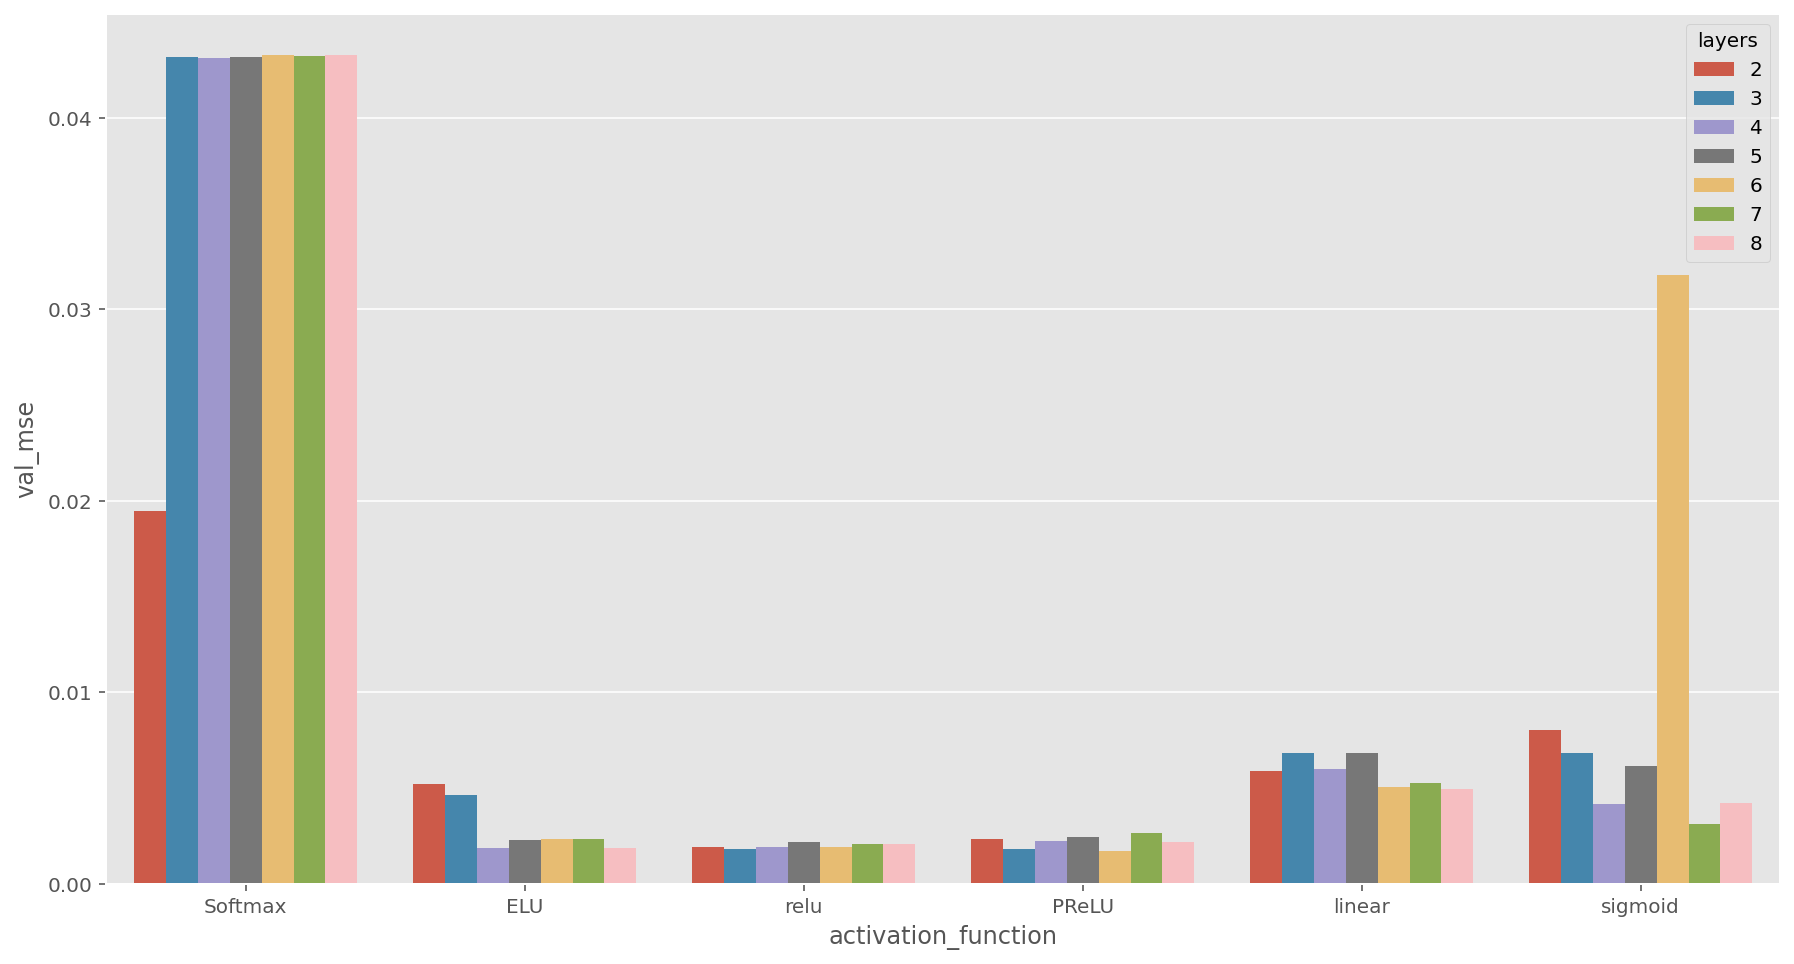

In [101]:
plt.figure(figsize = (15,8))
sns.barplot(x="activation_function", y="val_mse", hue="layers", data=activation_types_results).set_title("Barplot of Activation Function and validation MSE").set(xlabel='Activation Function', ylabel='Validation MSE')

plt.show()

As we are aiming to minimise validation MSE, both relu and PReLU activation functions perform well for our model. ELU appears to perform similarly for higher layer values.

The other activation functions are not suitable for our use case.

## Optimizer tuning
Based on the activation function results, we will use relu activation functions for our hidden layers as it produced the most consistently low validation MSE values.

We will keep all other hyperparameters the same as the previous test, only changing the optimizer.

In [105]:
def test_optimizers(x_train, x_test, y_train, y_test, optimizers, test_layers, epochs):
    """
    optimizers contains a 2d array, with each element representing a different optimizer.
    The first sub element represents the name of the optimizer, the second sub element 
    represents the optimizer object.
    """
    optimizers_results = pd.DataFrame(columns=['optimizer', 'layers', 'val_mse'])
    
    for optimizer in optimizers:
        for num_layers in test_layers:
            # Run full model with optimizer and num layer combo, then append results to dataframe
            model = keras.Sequential()
            model.add(layers.Dense(64, activation='relu', input_shape = [len(x_train.keys())])) # set initial input shape of model
            for layer in range(1, num_layers):
                model.add(layers.Dense(64, activation='relu'))
            model.add(layers.Dense(1, activation='linear'))
            model.compile(optimizer=optimizer[1],
                          loss='mean_squared_error',
                          metrics=['mean_squared_error'])
            
            #print(f"\n\n///////////////{optimizer[0]} {num_layers} layers/////////////////") # to check we are building the right model
#             print(model.summary())
            
            temporary_history = model.fit(x_train,
                                          y_train,
                                          epochs=epochs,
                                          verbose=0,
                                          validation_data=(x_test, y_test))
            extracted_hist = pd.DataFrame(temporary_history.history)
            extracted_hist['epoch'] = temporary_history.epoch
            #print(f"~~~~~~~~~~~~~~~~~ START MSE: {extracted_hist['val_loss'].iloc[0]} END MSE: {extracted_hist['val_loss'].iloc[-1]}")
            
            optimizers_results = optimizers_results.append({
                'optimizer': optimizer[0],
                'layers': num_layers,
                'val_mse': extracted_hist['val_loss'].iloc[-1]
            },
                ignore_index=True)
            
    return optimizers_results          
            
            

In [106]:
optimizers = [
    ["Adam", keras.optimizers.Adam()],
    ["Adadelta", keras.optimizers.Adadelta()],
    ["Adamax", keras.optimizers.Adamax()],
    ["RMSprop", keras.optimizers.RMSprop()],
    ["SGD", keras.optimizers.SGD()]
]
test_layers = [2, 3, 4, 5]
epochs = 5

activation_types_results = test_optimizers(x_train, x_test, y_train, y_test, optimizers, test_layers, epochs)



///////////////Adam 2 layers/////////////////
~~~~~~~~~~~~~~~~~ START MSE: 0.005278450902551413 END MSE: 0.0017854669131338596


///////////////Adam 3 layers/////////////////
~~~~~~~~~~~~~~~~~ START MSE: 0.0024119922891259193 END MSE: 0.001643627299927175


///////////////Adam 4 layers/////////////////
~~~~~~~~~~~~~~~~~ START MSE: 0.0039031754713505507 END MSE: 0.001811132999137044


///////////////Adam 5 layers/////////////////
~~~~~~~~~~~~~~~~~ START MSE: 0.0023917697835713625 END MSE: 0.001871888292953372


///////////////Adadelta 2 layers/////////////////
~~~~~~~~~~~~~~~~~ START MSE: 0.16043910384178162 END MSE: 0.1373158097267151


///////////////Adadelta 3 layers/////////////////
~~~~~~~~~~~~~~~~~ START MSE: 0.05420398339629173 END MSE: 0.05243510380387306


///////////////Adadelta 4 layers/////////////////
~~~~~~~~~~~~~~~~~ START MSE: 0.0691542774438858 END MSE: 0.060720980167388916


///////////////Adadelta 5 layers/////////////////
~~~~~~~~~~~~~~~~~ START MSE: 0.075309082865

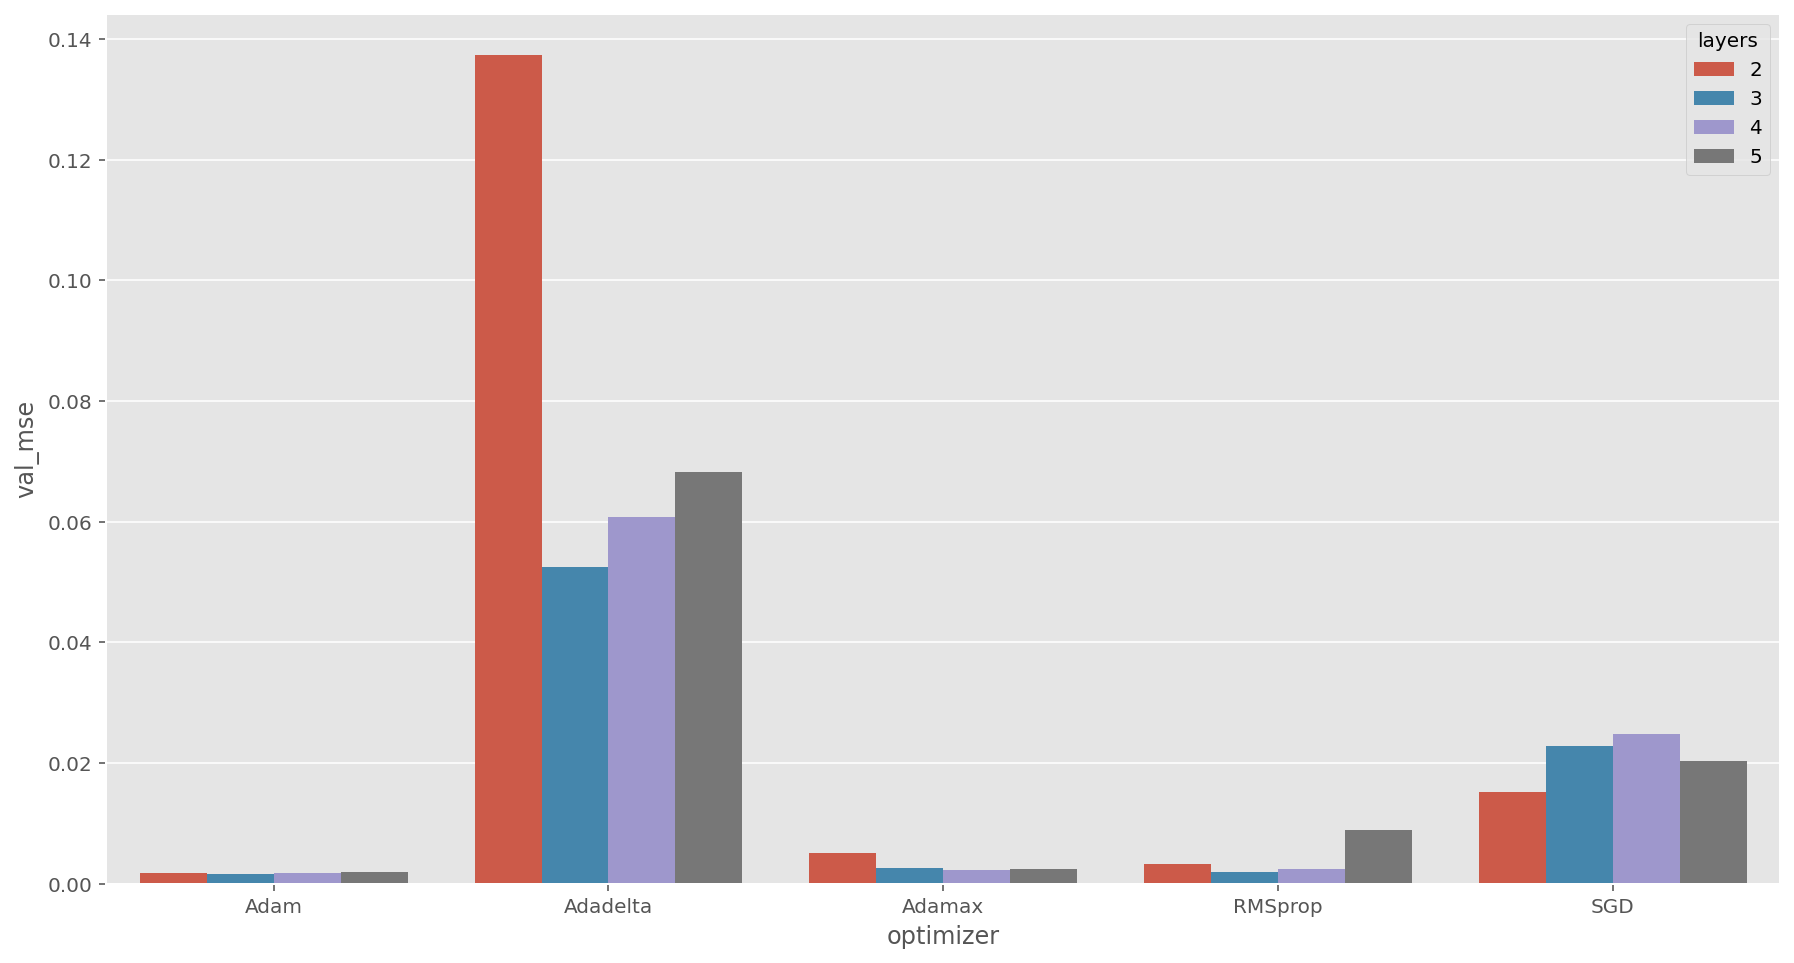

In [108]:
plt.figure(figsize = (15,8))
sns.barplot(x="optimizer", y="val_mse", hue="layers", data=activation_types_results).set_title("Barplot of Optimizer and validation MSE").set(xlabel='Optimizer', ylabel='Validation MSE')
plt.show()

The Adam optimizer as it produced the most consistently low validation MSE values for our model, with Adamax following closely behind for higher layer models.
* **Note:** the Adam optimizer may have performed the best for this test because we used it during the activation function tests. In other words, the relu function may be working best when paired with the Adam optimizer, or vice versa.
* This is a significant limitation of our testing methodology, as we do not have the resources to test the results when we pair these optimizers with a combination of different activation functions.

## Tuning network dimensions
Based on the activation function results, we will continue to use the Adam optimizer.

We will now test different dimensions for the neural network, and we will use the following rule-of-thumb methods as a guide for determining a testing range.

1. The number of hidden neurons should be between the size of the input layer and the size of the output layer.
2. The number of hidden neurons should be 2/3 the size of the input layer, plus the size of the output layer.
3. The number of hidden neurons should be less than twice the size of the input layer.

"Neural networks with two hidden layers can represent functions with any kind of shape. There is currently no theoretical reason to use neural networks with any more than two hidden layers. In fact, for many practical problems, there is no reason to use any more than one hidden layer." - From Introduction to Neural Networks for Java (second edition) by Jeff Heaton.

Heaton, J. (2008). The Number of Hidden Layers | Heaton Research. Retrieved 18 October 2021, from https://web.archive.org/web/20140721050413/http://www.heatonresearch.com/node/707

NOTE FROM FRANCIS: I'm assuming you found this quote online rather than reading the book, I found a reputable website that hosts the quote and have cited this site. Let me know if that's wrong.

Test hyper parameters:

**Number of layers (input + hidden): 2, 3, 4, 5**

**Number of neurons per layer: 8, 12, 16, 32, 64, 96**

In [110]:
def test_network_dimension(x_train, x_test, y_train, y_test, neurons_per_layer, test_layers, epochs):
    network_dimension_results = pd.DataFrame(columns=['neurons_per_layer', 'layers', 'val_mse'])
    
    for num_neurons in neurons_per_layer:
        for num_layers in test_layers:
            # Run full model with optimizer and num layer combo, then append results to dataframe
            model = keras.Sequential()
            model.add(layers.Dense(num_neurons, activation='relu', input_shape = [len(x_train.keys())])) # set initial input shape of model
            for layer in range(1, num_layers):
                model.add(layers.Dense(num_neurons, activation='relu'))
            model.add(layers.Dense(1, activation='linear'))
            model.compile(optimizer=keras.optimizers.Adam(),
                          loss='mean_squared_error',
                          metrics=['mean_squared_error'])
            
            #print(f"\n\n///////////////{num_layers} x {num_neurons}/////////////////") # to check we are building the right model
            #print(model.summary())
            
            temporary_history = model.fit(x_train,
                                          y_train,
                                          epochs=epochs,
                                          verbose=0,
                                          validation_data=(x_test, y_test))
            extracted_hist = pd.DataFrame(temporary_history.history)
            extracted_hist['epoch'] = temporary_history.epoch
            #print(f"~~~~~~~~~~~~~~~~~ START MSE: {extracted_hist['val_loss'].iloc[0]} END MSE: {extracted_hist['val_loss'].iloc[-1]}")
            
            network_dimension_results = network_dimension_results.append({
                'neurons_per_layer': num_neurons,
                'layers': num_layers,
                'val_mse': extracted_hist['val_loss'].iloc[-1]
            },
                ignore_index=True)
            
    return network_dimension_results
            
            

In [138]:
neurons_per_layer = [8, 12, 16, 32, 64, 96, 128]
test_layers = [2, 3, 4, 5, 6, 7]
epochs = 5

network_dimension_results = test_network_dimension(x_train, x_test, y_train, y_test, neurons_per_layer, test_layers, epochs)



///////////////2 x 8/////////////////
Model: "sequential_252"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_1200 (Dense)           (None, 8)                 216       
_________________________________________________________________
dense_1201 (Dense)           (None, 8)                 72        
_________________________________________________________________
dense_1202 (Dense)           (None, 1)                 9         
Total params: 297
Trainable params: 297
Non-trainable params: 0
_________________________________________________________________
None
~~~~~~~~~~~~~~~~~ START MSE: 0.022537440061569214 END MSE: 0.004096519201993942


///////////////3 x 8/////////////////
Model: "sequential_253"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_1203 (Dense)           (None, 8)                 216     

~~~~~~~~~~~~~~~~~ START MSE: 0.021258892491459846 END MSE: 0.0026069225277751684


///////////////4 x 12/////////////////
Model: "sequential_260"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_1240 (Dense)           (None, 12)                324       
_________________________________________________________________
dense_1241 (Dense)           (None, 12)                156       
_________________________________________________________________
dense_1242 (Dense)           (None, 12)                156       
_________________________________________________________________
dense_1243 (Dense)           (None, 12)                156       
_________________________________________________________________
dense_1244 (Dense)           (None, 1)                 13        
Total params: 805
Trainable params: 805
Non-trainable params: 0
________________________________________________________________

~~~~~~~~~~~~~~~~~ START MSE: 0.028994247317314148 END MSE: 0.0021681191865354776


///////////////5 x 16/////////////////
Model: "sequential_267"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_1278 (Dense)           (None, 16)                432       
_________________________________________________________________
dense_1279 (Dense)           (None, 16)                272       
_________________________________________________________________
dense_1280 (Dense)           (None, 16)                272       
_________________________________________________________________
dense_1281 (Dense)           (None, 16)                272       
_________________________________________________________________
dense_1282 (Dense)           (None, 16)                272       
_________________________________________________________________
dense_1283 (Dense)           (None, 1)                 17     

~~~~~~~~~~~~~~~~~ START MSE: 0.0050191269256174564 END MSE: 0.0017335840966552496


///////////////6 x 32/////////////////
Model: "sequential_274"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_1317 (Dense)           (None, 32)                864       
_________________________________________________________________
dense_1318 (Dense)           (None, 32)                1056      
_________________________________________________________________
dense_1319 (Dense)           (None, 32)                1056      
_________________________________________________________________
dense_1320 (Dense)           (None, 32)                1056      
_________________________________________________________________
dense_1321 (Dense)           (None, 32)                1056      
_________________________________________________________________
dense_1322 (Dense)           (None, 32)                1056  

~~~~~~~~~~~~~~~~~ START MSE: 0.0025799251161515713 END MSE: 0.0017863644752651453


///////////////7 x 64/////////////////
Model: "sequential_281"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_1357 (Dense)           (None, 64)                1728      
_________________________________________________________________
dense_1358 (Dense)           (None, 64)                4160      
_________________________________________________________________
dense_1359 (Dense)           (None, 64)                4160      
_________________________________________________________________
dense_1360 (Dense)           (None, 64)                4160      
_________________________________________________________________
dense_1361 (Dense)           (None, 64)                4160      
_________________________________________________________________
dense_1362 (Dense)           (None, 64)                4160  

~~~~~~~~~~~~~~~~~ START MSE: 0.002171936212107539 END MSE: 0.0018051874358206987


///////////////2 x 128/////////////////
Model: "sequential_288"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_1398 (Dense)           (None, 128)               3456      
_________________________________________________________________
dense_1399 (Dense)           (None, 128)               16512     
_________________________________________________________________
dense_1400 (Dense)           (None, 1)                 129       
Total params: 20,097
Trainable params: 20,097
Non-trainable params: 0
_________________________________________________________________
None
~~~~~~~~~~~~~~~~~ START MSE: 0.005823381245136261 END MSE: 0.0021259658969938755


///////////////3 x 128/////////////////
Model: "sequential_289"
_________________________________________________________________
Layer (type)                 Output S

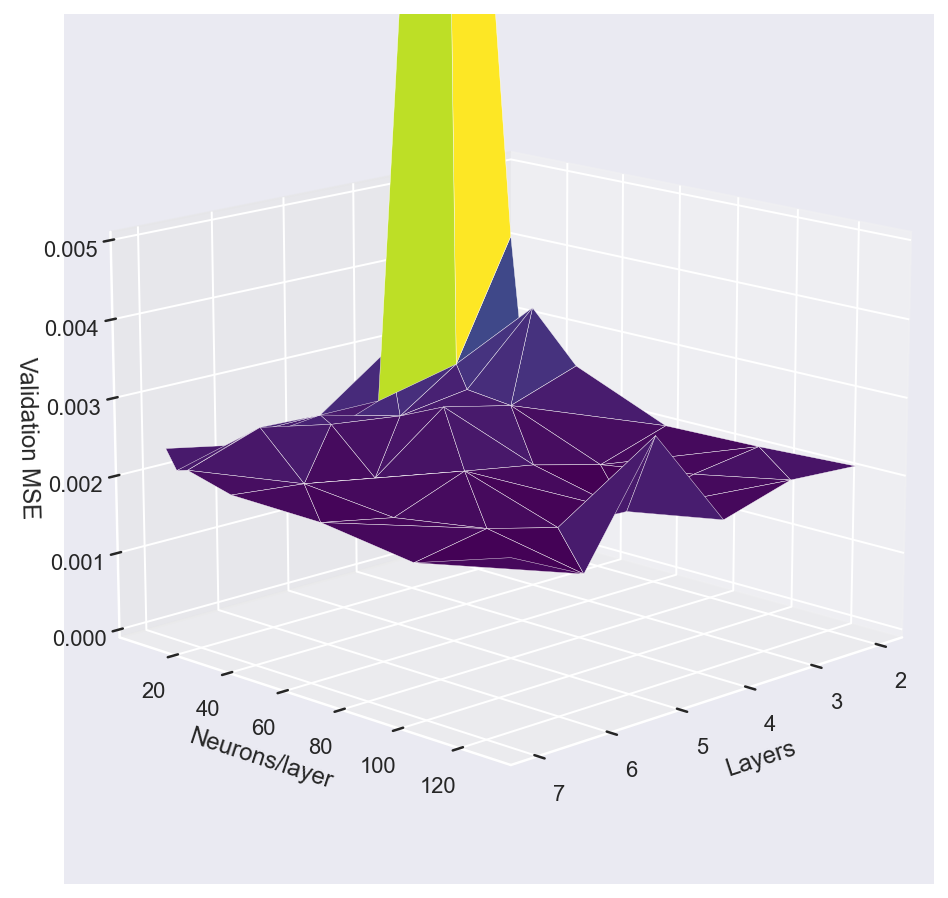

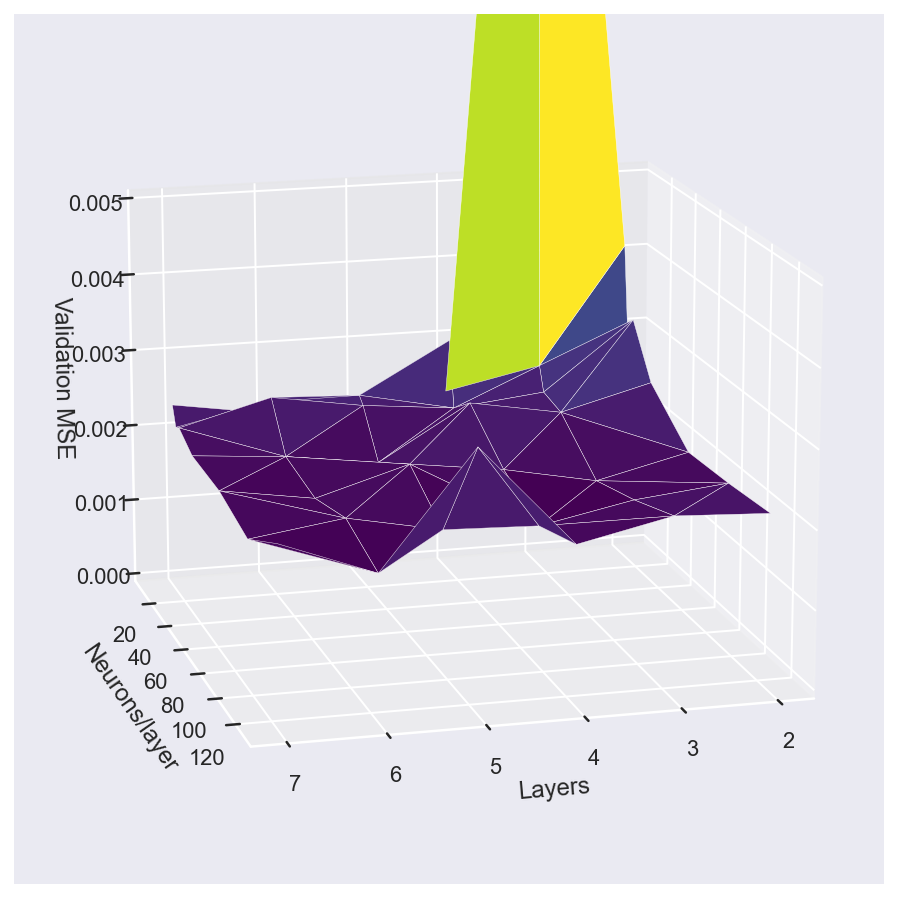

In [145]:
from mpl_toolkits.mplot3d import Axes3D
sns.set(style = "darkgrid")


x = network_dimension_results['layers']
y = network_dimension_results['neurons_per_layer']
z = network_dimension_results['val_mse']


fig = plt.figure(figsize = (8,8))
ax = fig.gca(projection='3d')
ax.set_zlim([0, 0.005])
ax.set_xlabel('Layers')
ax.set_ylabel('Neurons/layer')
ax.set_zlabel('Validation MSE')
ax.set_title("Surfplot of Layers, Neurons/layer and Validation MSE")
ax.plot_trisurf(x, y, z, cmap=plt.cm.viridis, linewidth=0.2)
ax.view_init(15, 45)
plt.show()

fig = plt.figure(figsize = (8,8))
ax = fig.gca(projection='3d')
ax.set_zlim([0, 0.005])
ax.set_xlabel('Layers')
ax.set_ylabel('Neurons/layer')
ax.set_zlabel('Validation MSE')
ax.set_title("Surfplot of Layers, Neurons/layer and Validation MSE - alternate angle")
surf=ax.plot_trisurf(x, y, z, cmap=plt.cm.viridis, linewidth=0.2)
ax.view_init(15, 75)
plt.show()

Based on the dimension results, validation MSE appears to minimise when neurons/layer > 40 and when layers > 3. Validation MSE is extremely high when both layers and neurons/layer are too low.

However, 2 layers appears to be sufficient with 80+ neurons/layer. And 8 neurons/layer appear to be sufficient with 6+ layers. Once either variable reaches a certain size, validation MSE does not appear to improve anymore. 

## Tuning batch size
From the above network dimension results, we will take the network dimension with the minimum MSE from the above test.
* This is a dimension of 4 layers with 96 neurons per layer.

Finally, we will manually test for the effect of using different batch sizes. With the default batch size being 32, we will artibrarily select a range of batch sizes from 1 to 1024 to test it's effect on model performance.

In [151]:
print("MAX MSE: ")
print(network_dimension_results[network_dimension_results["val_mse"] == network_dimension_results["val_mse"].max()])

print("\nMIN MSE: ")
print(network_dimension_results[network_dimension_results["val_mse"] == network_dimension_results["val_mse"].min()])

MAX MSE: 
   neurons_per_layer  layers   val_mse
1                8.0     3.0  0.017012

MIN MSE: 
    neurons_per_layer  layers   val_mse
32               96.0     4.0  0.001701


In [152]:
def test_batch_size(x_train, x_test, y_train, y_test, batch_sizes, epochs):
    batch_size_results = pd.DataFrame(columns=['batch_size', 'val_mse'])
    
    for batch_size in batch_sizes:
        model = keras.Sequential()
        model.add(layers.Dense(96, activation='relu', input_shape = [len(x_train.keys())])) # set initial input shape of model
        for layer in range(1, 4):
            model.add(layers.Dense(96, activation='relu'))
        model.add(layers.Dense(1, activation='linear'))
        model.compile(optimizer=keras.optimizers.Adam(),
                      loss='mean_squared_error',
                      metrics=['mean_squared_error'])

        #print(f"\n\n///////////////Batch size: {batch_size}/////////////////") # to check we are building the right model
        #print(model.summary())

        temporary_history = model.fit(x_train,
                                      y_train,
                                      epochs=epochs,
                                      verbose=0,
                                      validation_data=(x_test, y_test))
        extracted_hist = pd.DataFrame(temporary_history.history)
        extracted_hist['epoch'] = temporary_history.epoch
        #print(f"~~~~~~~~~~~~~~~~~ START MSE: {extracted_hist['val_loss'].iloc[0]} END MSE: {extracted_hist['val_loss'].iloc[-1]}")

        batch_size_results = batch_size_results.append({
            'batch_size': batch_size,
            'val_mse': extracted_hist['val_loss'].iloc[-1]
        },
            ignore_index=True)
            
    return batch_size_results
            
            

In [156]:
batch_sizes = [1, 4, 8, 16, 32, 64, 128, 256, 512, 1024]
epochs = 5

batch_size_results_5_epoch = test_batch_size(x_train, x_test, y_train, y_test, batch_sizes, epochs)



///////////////Batch size: 1/////////////////
Model: "sequential_304"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_1481 (Dense)           (None, 96)                2592      
_________________________________________________________________
dense_1482 (Dense)           (None, 96)                9312      
_________________________________________________________________
dense_1483 (Dense)           (None, 96)                9312      
_________________________________________________________________
dense_1484 (Dense)           (None, 96)                9312      
_________________________________________________________________
dense_1485 (Dense)           (None, 1)                 97        
Total params: 30,625
Trainable params: 30,625
Non-trainable params: 0
_________________________________________________________________
None
~~~~~~~~~~~~~~~~~ START MSE: 0.003258120734244585 END MSE: 0.

~~~~~~~~~~~~~~~~~ START MSE: 0.002980455057695508 END MSE: 0.0021746656857430935


///////////////Batch size: 512/////////////////
Model: "sequential_312"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_1521 (Dense)           (None, 96)                2592      
_________________________________________________________________
dense_1522 (Dense)           (None, 96)                9312      
_________________________________________________________________
dense_1523 (Dense)           (None, 96)                9312      
_________________________________________________________________
dense_1524 (Dense)           (None, 96)                9312      
_________________________________________________________________
dense_1525 (Dense)           (None, 1)                 97        
Total params: 30,625
Trainable params: 30,625
Non-trainable params: 0
_________________________________________________

<AxesSubplot:xlabel='log_batch_size', ylabel='val_mse'>

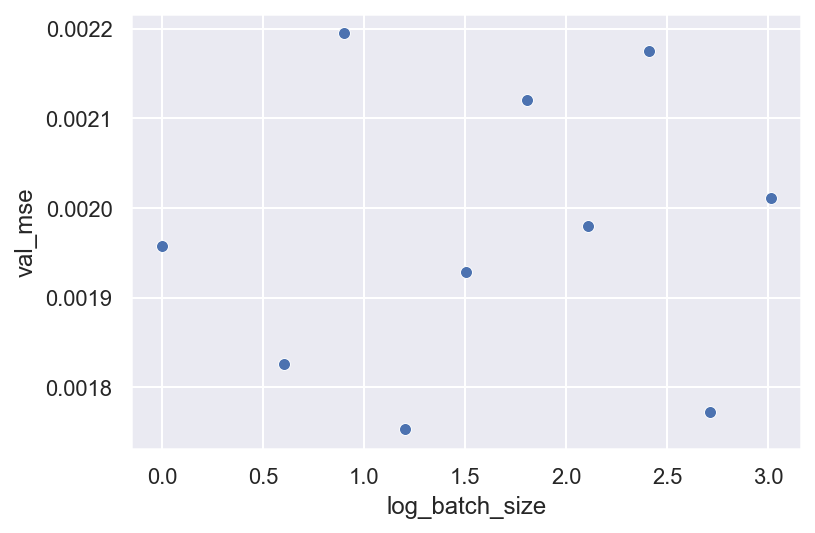

In [157]:
batch_size_results_5_epoch["log_batch_size"] = np.log10(batch_size_results_5_epoch["batch_size"])
sns.scatterplot(x="log_batch_size", y="val_mse", data=batch_size_results_5_epoch).set_title("Scatterplot of Log(Batch size) and validation MSE for 5 epochs").set(xlabel='Log(Batch size)', ylabel='Validation MSE')

In [158]:
batch_sizes = [1, 4, 8, 16, 32, 64, 128, 256, 512, 1024]
epochs = 25

batch_size_results_25_epoch = test_batch_size(x_train, x_test, y_train, y_test, batch_sizes, epochs)



///////////////Batch size: 1/////////////////
Model: "sequential_314"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_1531 (Dense)           (None, 96)                2592      
_________________________________________________________________
dense_1532 (Dense)           (None, 96)                9312      
_________________________________________________________________
dense_1533 (Dense)           (None, 96)                9312      
_________________________________________________________________
dense_1534 (Dense)           (None, 96)                9312      
_________________________________________________________________
dense_1535 (Dense)           (None, 1)                 97        
Total params: 30,625
Trainable params: 30,625
Non-trainable params: 0
_________________________________________________________________
None
~~~~~~~~~~~~~~~~~ START MSE: 0.0030091286171227694 END MSE: 0

~~~~~~~~~~~~~~~~~ START MSE: 0.0032903202809393406 END MSE: 0.0017403657548129559


///////////////Batch size: 512/////////////////
Model: "sequential_322"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_1571 (Dense)           (None, 96)                2592      
_________________________________________________________________
dense_1572 (Dense)           (None, 96)                9312      
_________________________________________________________________
dense_1573 (Dense)           (None, 96)                9312      
_________________________________________________________________
dense_1574 (Dense)           (None, 96)                9312      
_________________________________________________________________
dense_1575 (Dense)           (None, 1)                 97        
Total params: 30,625
Trainable params: 30,625
Non-trainable params: 0
________________________________________________

<AxesSubplot:xlabel='log_batch_size', ylabel='val_mse'>

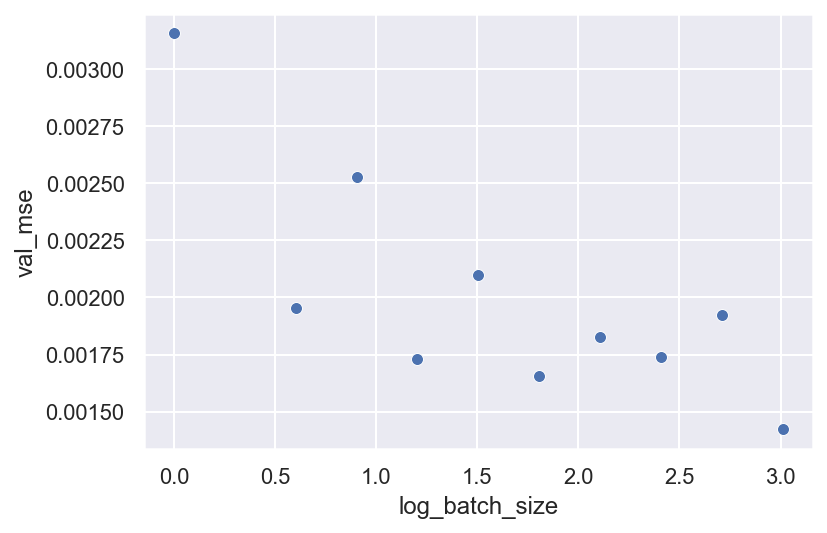

In [159]:
batch_size_results_25_epoch["log_batch_size"] = np.log10(batch_size_results_25_epoch["batch_size"])
sns.scatterplot(x="log_batch_size", y="val_mse", data=batch_size_results_25_epoch).set_title("Scatterplot of Log(Batch size) and validation MSE for 10 epochs").set(xlabel='Log(Batch size)', ylabel='Validation MSE')

Based on the plots, batch size for models trained with low epochs appears to have a minimal effect on val_mse for our model. Although, there appears to be a negative relationship between val_mse and batch size when we use a higher epoch value.

However, according to - _On Large-Batch Training for Deep Learning: Generalization Gap and Sharp Minima, Nitish Shirish Keska et al, ICLR 2017._, citation: https://arxiv.org/abs/1609.04836 large batchsizes are observed to cause over-fitting. Even though a batch size of 1024 appears to produce the lowest val_mse, we will take caution and tune the epoch hyperparameter using both the default batch size of 32 and a batch size of 1024.

Keskar, N., Mudigere, D., Nocedal, J., Smelyanskiy, M., & Tang, P. (2017). On Large-Batch Training for Deep Learning: Generalization Gap and Sharp Minima. In International Conference on Learning Representations. Ithaca, New York: Cornell.

# Tuning epochs
Finally, we will tune for the optimal number of epochs. We will keep the follow hyperparameters static:
* Adam optimizer
* relu activation functions for hidden layers
* MSE loss function
* 96 neurons/layer
* 1 x input layer, 3 x hidden layers, 1 x output layer
* batch size: 32 OR 1024

We are looking for the ideal epoch value that minimises val_MSE. In this section, we are mainly testing whether or not the model is generalising and performing well with our validation data which we have reserved. We are keeping an eye on signs for overfitting (initially decreasing val_MSE, that starts to increase after a certain epoch value).

In [174]:
def build_model():
    model = keras.Sequential([
        layers.Dense(96, activation=tf.nn.relu, input_shape = [len(x_train.keys())]),
        layers.Dense(96, activation=tf.nn.relu),
        layers.Dense(96, activation=tf.nn.relu),
        layers.Dense(96, activation=tf.nn.relu),
        layers.Dense(1, activation="linear")
    ])
    
    optimizer = tf.keras.optimizers.Adam()
    
    model.compile(loss='mse',
                  optimizer=optimizer)
    
    return model

In [194]:
model1 = build_model()
model1.summary()

Model: "sequential_331"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_1616 (Dense)           (None, 96)                2592      
_________________________________________________________________
dense_1617 (Dense)           (None, 96)                9312      
_________________________________________________________________
dense_1618 (Dense)           (None, 96)                9312      
_________________________________________________________________
dense_1619 (Dense)           (None, 96)                9312      
_________________________________________________________________
dense_1620 (Dense)           (None, 1)                 97        
Total params: 30,625
Trainable params: 30,625
Non-trainable params: 0
_________________________________________________________________


In [195]:
history_32_batch_size = model.fit(x_train, 
                                    y_train, 
                                    epochs=400, 
                                    validation_data=(x_test, y_test),
                                    verbose=0)

Epoch 1/400
135/135 [==============================] - 0s 1ms/step - loss: 0.0148 - val_loss: 0.0026
Epoch 2/400
135/135 [==============================] - 0s 844us/step - loss: 0.0023 - val_loss: 0.0018
Epoch 3/400
135/135 [==============================] - 0s 852us/step - loss: 0.0018 - val_loss: 0.0019
Epoch 4/400
135/135 [==============================] - 0s 829us/step - loss: 0.0017 - val_loss: 0.0019
Epoch 5/400
135/135 [==============================] - 0s 822us/step - loss: 0.0016 - val_loss: 0.0017
Epoch 6/400
135/135 [==============================] - 0s 829us/step - loss: 0.0014 - val_loss: 0.0020
Epoch 7/400
135/135 [==============================] - 0s 919us/step - loss: 0.0014 - val_loss: 0.0019
Epoch 8/400
135/135 [==============================] - 0s 837us/step - loss: 0.0016 - val_loss: 0.0028
Epoch 9/400
135/135 [==============================] - 0s 829us/step - loss: 0.0013 - val_loss: 0.0019
Epoch 10/400
135/135 [==============================] - 0s 822us/step - los

135/135 [==============================] - 0s 807us/step - loss: 5.4120e-04 - val_loss: 0.0016
Epoch 154/400
135/135 [==============================] - 0s 874us/step - loss: 5.4963e-04 - val_loss: 0.0015
Epoch 155/400
135/135 [==============================] - 0s 807us/step - loss: 5.3247e-04 - val_loss: 0.0014
Epoch 156/400
135/135 [==============================] - 0s 859us/step - loss: 5.4926e-04 - val_loss: 0.0015
Epoch 157/400
135/135 [==============================] - 0s 911us/step - loss: 5.6523e-04 - val_loss: 0.0015
Epoch 158/400
135/135 [==============================] - 0s 837us/step - loss: 5.5413e-04 - val_loss: 0.0014
Epoch 159/400
135/135 [==============================] - 0s 829us/step - loss: 5.4250e-04 - val_loss: 0.0014
Epoch 160/400
135/135 [==============================] - 0s 896us/step - loss: 6.2114e-04 - val_loss: 0.0015
Epoch 161/400
135/135 [==============================] - 0s 837us/step - loss: 5.3099e-04 - val_loss: 0.0014
Epoch 162/400
135/135 [==========

135/135 [==============================] - 0s 829us/step - loss: 4.4009e-04 - val_loss: 0.0015
Epoch 304/400
135/135 [==============================] - 0s 822us/step - loss: 5.0375e-04 - val_loss: 0.0014
Epoch 305/400
135/135 [==============================] - 0s 822us/step - loss: 4.0225e-04 - val_loss: 0.0014
Epoch 306/400
135/135 [==============================] - 0s 814us/step - loss: 3.6872e-04 - val_loss: 0.0014
Epoch 307/400
135/135 [==============================] - 0s 837us/step - loss: 3.6851e-04 - val_loss: 0.0015
Epoch 308/400
135/135 [==============================] - 0s 822us/step - loss: 4.0038e-04 - val_loss: 0.0014
Epoch 309/400
135/135 [==============================] - 0s 829us/step - loss: 3.7343e-04 - val_loss: 0.0016
Epoch 310/400
135/135 [==============================] - 0s 822us/step - loss: 3.8653e-04 - val_loss: 0.0015
Epoch 311/400
135/135 [==============================] - 0s 837us/step - loss: 3.7658e-04 - val_loss: 0.0016
Epoch 312/400
135/135 [==========

In [196]:
hist = pd.DataFrame(history_32_batch_size.history)
hist['epoch'] = history_32_batch_size.epoch

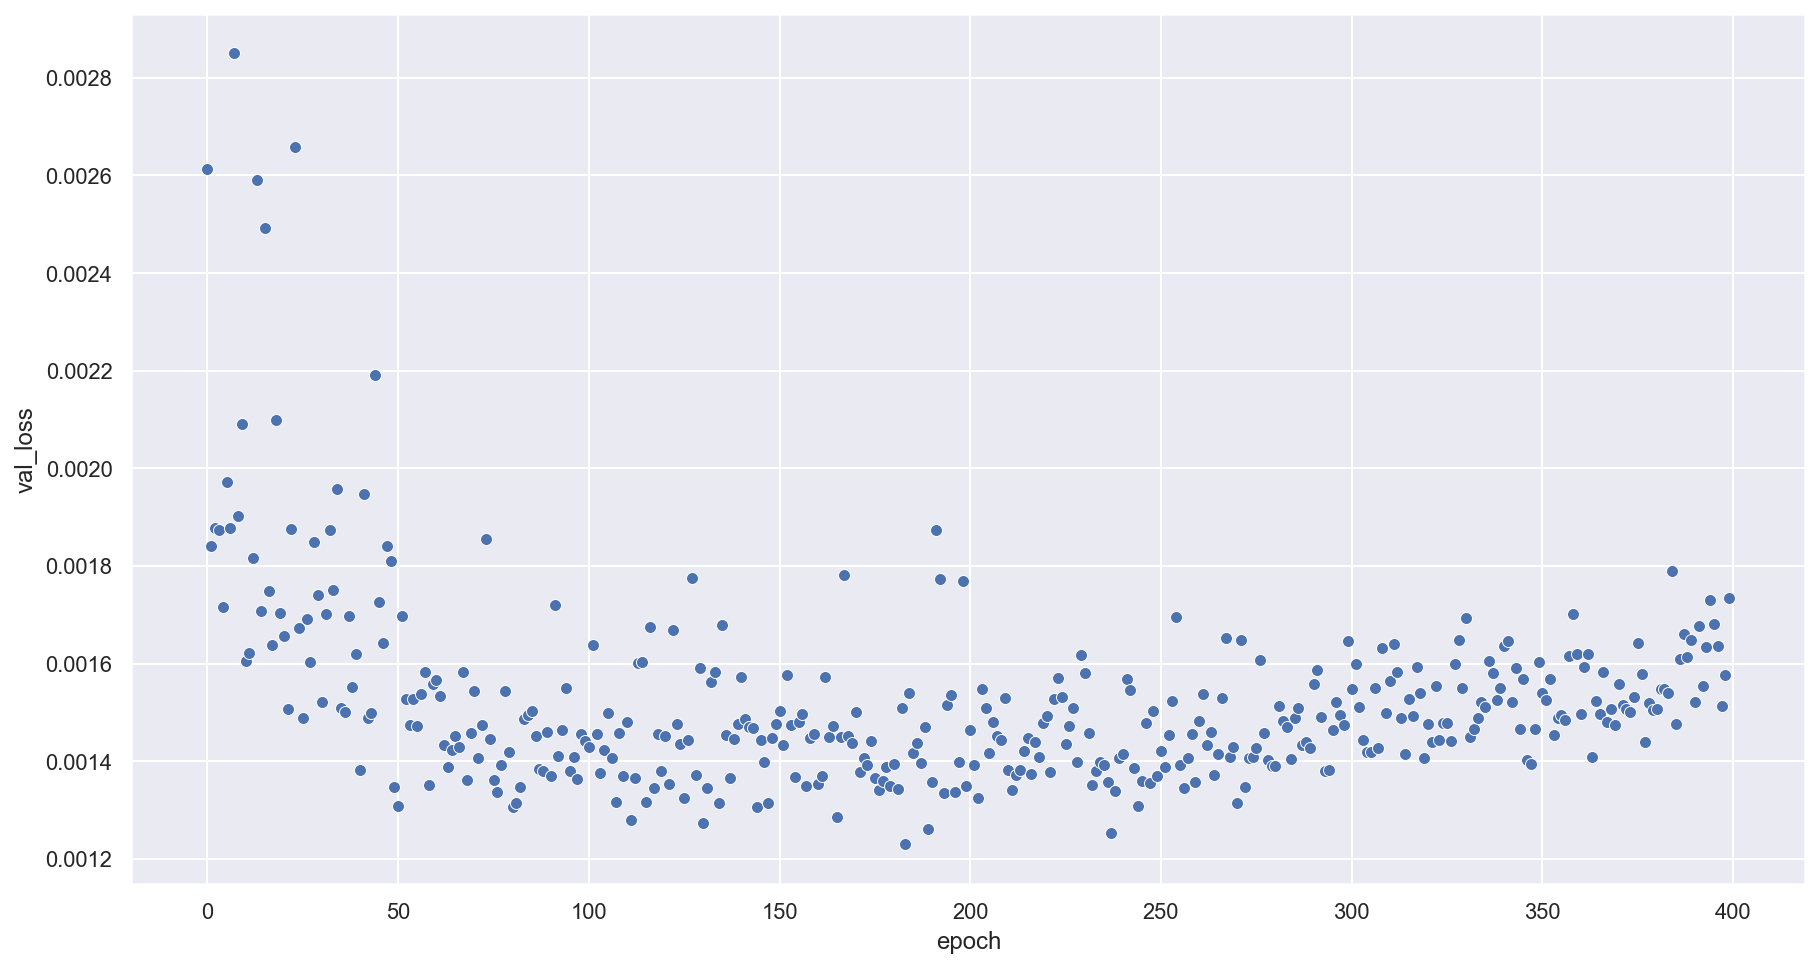

In [197]:
plt.figure(figsize = (15,8))
sns.scatterplot(x=hist['epoch'], y=hist['val_loss']).set_title("Scatterplot of Epoch and validation MSE for 32 batch size").set(xlabel='Epoch', ylabel='Validation MSE')
plt.show()

In [190]:
model2 = build_model()

In [191]:
history_1024_batch_size = model2.fit(x_train, 
                                    y_train, 
                                    epochs=800, 
                                    validation_data=(x_test, y_test),
                                    verbose=0,
                                    batch_size=1024)

Epoch 1/800
5/5 [==============================] - 0s 23ms/step - loss: 0.0817 - val_loss: 0.0477
Epoch 2/800
5/5 [==============================] - 0s 6ms/step - loss: 0.0516 - val_loss: 0.0406
Epoch 3/800
5/5 [==============================] - 0s 6ms/step - loss: 0.0401 - val_loss: 0.0330
Epoch 4/800
5/5 [==============================] - 0s 6ms/step - loss: 0.0355 - val_loss: 0.0274
Epoch 5/800
5/5 [==============================] - 0s 6ms/step - loss: 0.0286 - val_loss: 0.0217
Epoch 6/800
5/5 [==============================] - 0s 6ms/step - loss: 0.0219 - val_loss: 0.0155
Epoch 7/800
5/5 [==============================] - 0s 6ms/step - loss: 0.0161 - val_loss: 0.0117
Epoch 8/800
5/5 [==============================] - 0s 6ms/step - loss: 0.0118 - val_loss: 0.0079
Epoch 9/800
5/5 [==============================] - 0s 6ms/step - loss: 0.0080 - val_loss: 0.0061
Epoch 10/800
5/5 [==============================] - 0s 6ms/step - loss: 0.0057 - val_loss: 0.0050
Epoch 11/800
5/5 [==========

5/5 [==============================] - 0s 6ms/step - loss: 7.0766e-04 - val_loss: 0.0016
Epoch 162/800
5/5 [==============================] - 0s 6ms/step - loss: 6.4714e-04 - val_loss: 0.0015
Epoch 163/800
5/5 [==============================] - 0s 6ms/step - loss: 6.4334e-04 - val_loss: 0.0017
Epoch 164/800
5/5 [==============================] - 0s 6ms/step - loss: 6.2846e-04 - val_loss: 0.0017
Epoch 165/800
5/5 [==============================] - 0s 6ms/step - loss: 6.5815e-04 - val_loss: 0.0017
Epoch 166/800
5/5 [==============================] - 0s 6ms/step - loss: 6.5951e-04 - val_loss: 0.0015
Epoch 167/800
5/5 [==============================] - ETA: 0s - loss: 6.3188e-0 - 0s 6ms/step - loss: 6.4903e-04 - val_loss: 0.0015
Epoch 168/800
5/5 [==============================] - 0s 6ms/step - loss: 6.3590e-04 - val_loss: 0.0016
Epoch 169/800
5/5 [==============================] - 0s 6ms/step - loss: 6.2691e-04 - val_loss: 0.0016
Epoch 170/800
5/5 [==============================] - 0s 6ms

5/5 [==============================] - 0s 6ms/step - loss: 5.2911e-04 - val_loss: 0.0016
Epoch 320/800
5/5 [==============================] - 0s 6ms/step - loss: 5.3900e-04 - val_loss: 0.0016
Epoch 321/800
5/5 [==============================] - 0s 6ms/step - loss: 5.3013e-04 - val_loss: 0.0016
Epoch 322/800
5/5 [==============================] - 0s 6ms/step - loss: 5.5387e-04 - val_loss: 0.0016
Epoch 323/800
5/5 [==============================] - 0s 6ms/step - loss: 6.1134e-04 - val_loss: 0.0016
Epoch 324/800
5/5 [==============================] - 0s 6ms/step - loss: 6.8106e-04 - val_loss: 0.0016
Epoch 325/800
5/5 [==============================] - 0s 6ms/step - loss: 6.4694e-04 - val_loss: 0.0019
Epoch 326/800
5/5 [==============================] - 0s 6ms/step - loss: 7.0880e-04 - val_loss: 0.0018
Epoch 327/800
5/5 [==============================] - 0s 6ms/step - loss: 6.2546e-04 - val_loss: 0.0016
Epoch 328/800
5/5 [==============================] - 0s 6ms/step - loss: 5.4771e-04 - v

5/5 [==============================] - 0s 6ms/step - loss: 5.2334e-04 - val_loss: 0.0016
Epoch 478/800
5/5 [==============================] - 0s 6ms/step - loss: 4.7873e-04 - val_loss: 0.0016
Epoch 479/800
5/5 [==============================] - 0s 7ms/step - loss: 4.6910e-04 - val_loss: 0.0017
Epoch 480/800
5/5 [==============================] - 0s 6ms/step - loss: 4.9817e-04 - val_loss: 0.0016
Epoch 481/800
5/5 [==============================] - 0s 6ms/step - loss: 4.8502e-04 - val_loss: 0.0016
Epoch 482/800
5/5 [==============================] - 0s 6ms/step - loss: 4.7312e-04 - val_loss: 0.0016
Epoch 483/800
5/5 [==============================] - 0s 6ms/step - loss: 4.6302e-04 - val_loss: 0.0016
Epoch 484/800
5/5 [==============================] - 0s 6ms/step - loss: 5.1517e-04 - val_loss: 0.0015
Epoch 485/800
5/5 [==============================] - 0s 6ms/step - loss: 5.1356e-04 - val_loss: 0.0016
Epoch 486/800
5/5 [==============================] - 0s 6ms/step - loss: 4.7097e-04 - v

5/5 [==============================] - 0s 6ms/step - loss: 4.5782e-04 - val_loss: 0.0016
Epoch 636/800
5/5 [==============================] - 0s 6ms/step - loss: 4.2619e-04 - val_loss: 0.0016
Epoch 637/800
5/5 [==============================] - 0s 6ms/step - loss: 4.2207e-04 - val_loss: 0.0017
Epoch 638/800
5/5 [==============================] - 0s 6ms/step - loss: 4.2950e-04 - val_loss: 0.0017
Epoch 639/800
5/5 [==============================] - 0s 6ms/step - loss: 4.1171e-04 - val_loss: 0.0016
Epoch 640/800
5/5 [==============================] - 0s 6ms/step - loss: 4.1084e-04 - val_loss: 0.0017
Epoch 641/800
5/5 [==============================] - 0s 6ms/step - loss: 4.2429e-04 - val_loss: 0.0017
Epoch 642/800
5/5 [==============================] - 0s 6ms/step - loss: 4.4376e-04 - val_loss: 0.0016
Epoch 643/800
5/5 [==============================] - 0s 6ms/step - loss: 4.9528e-04 - val_loss: 0.0017
Epoch 644/800
5/5 [==============================] - 0s 6ms/step - loss: 5.6970e-04 - v

5/5 [==============================] - 0s 6ms/step - loss: 3.6847e-04 - val_loss: 0.0017
Epoch 794/800
5/5 [==============================] - 0s 6ms/step - loss: 3.5602e-04 - val_loss: 0.0017
Epoch 795/800
5/5 [==============================] - 0s 6ms/step - loss: 3.5595e-04 - val_loss: 0.0017
Epoch 796/800
5/5 [==============================] - 0s 6ms/step - loss: 3.6733e-04 - val_loss: 0.0017
Epoch 797/800
5/5 [==============================] - 0s 6ms/step - loss: 3.7538e-04 - val_loss: 0.0016
Epoch 798/800
5/5 [==============================] - 0s 6ms/step - loss: 3.6648e-04 - val_loss: 0.0017
Epoch 799/800
5/5 [==============================] - 0s 6ms/step - loss: 4.0378e-04 - val_loss: 0.0017
Epoch 800/800
5/5 [==============================] - 0s 6ms/step - loss: 4.1263e-04 - val_loss: 0.0017


In [192]:
hist = pd.DataFrame(history_1024_batch_size.history)
hist['epoch'] = history_1024_batch_size.epoch

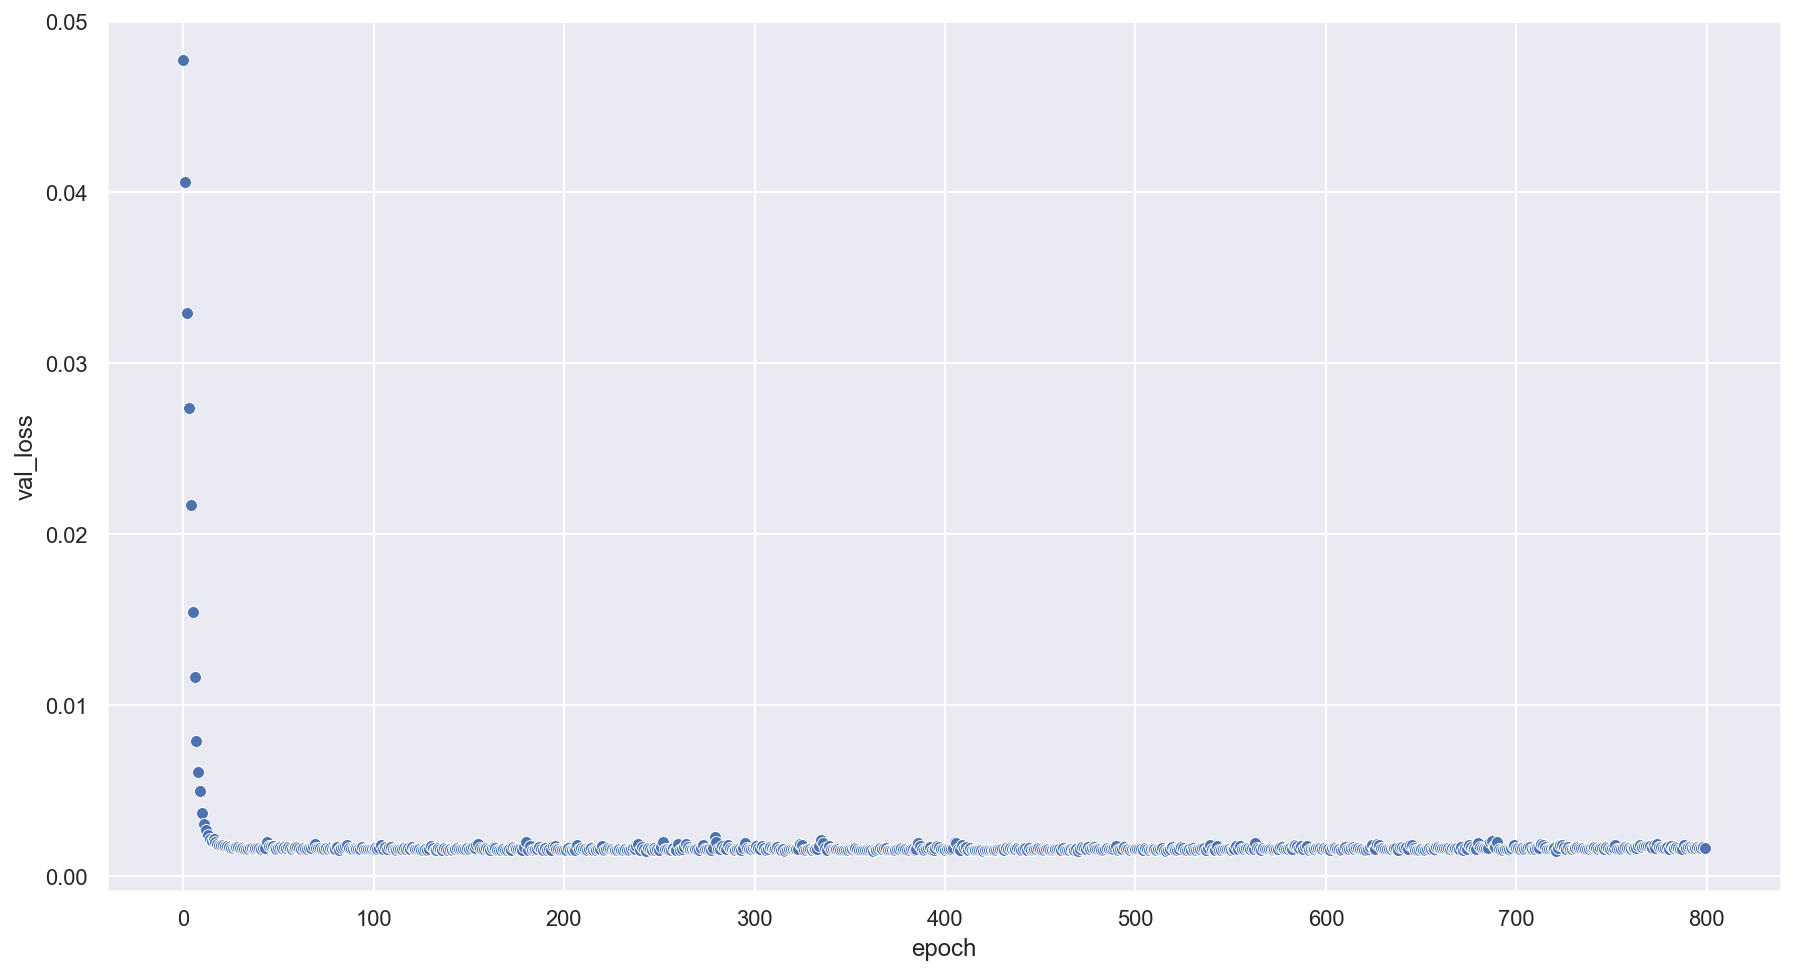

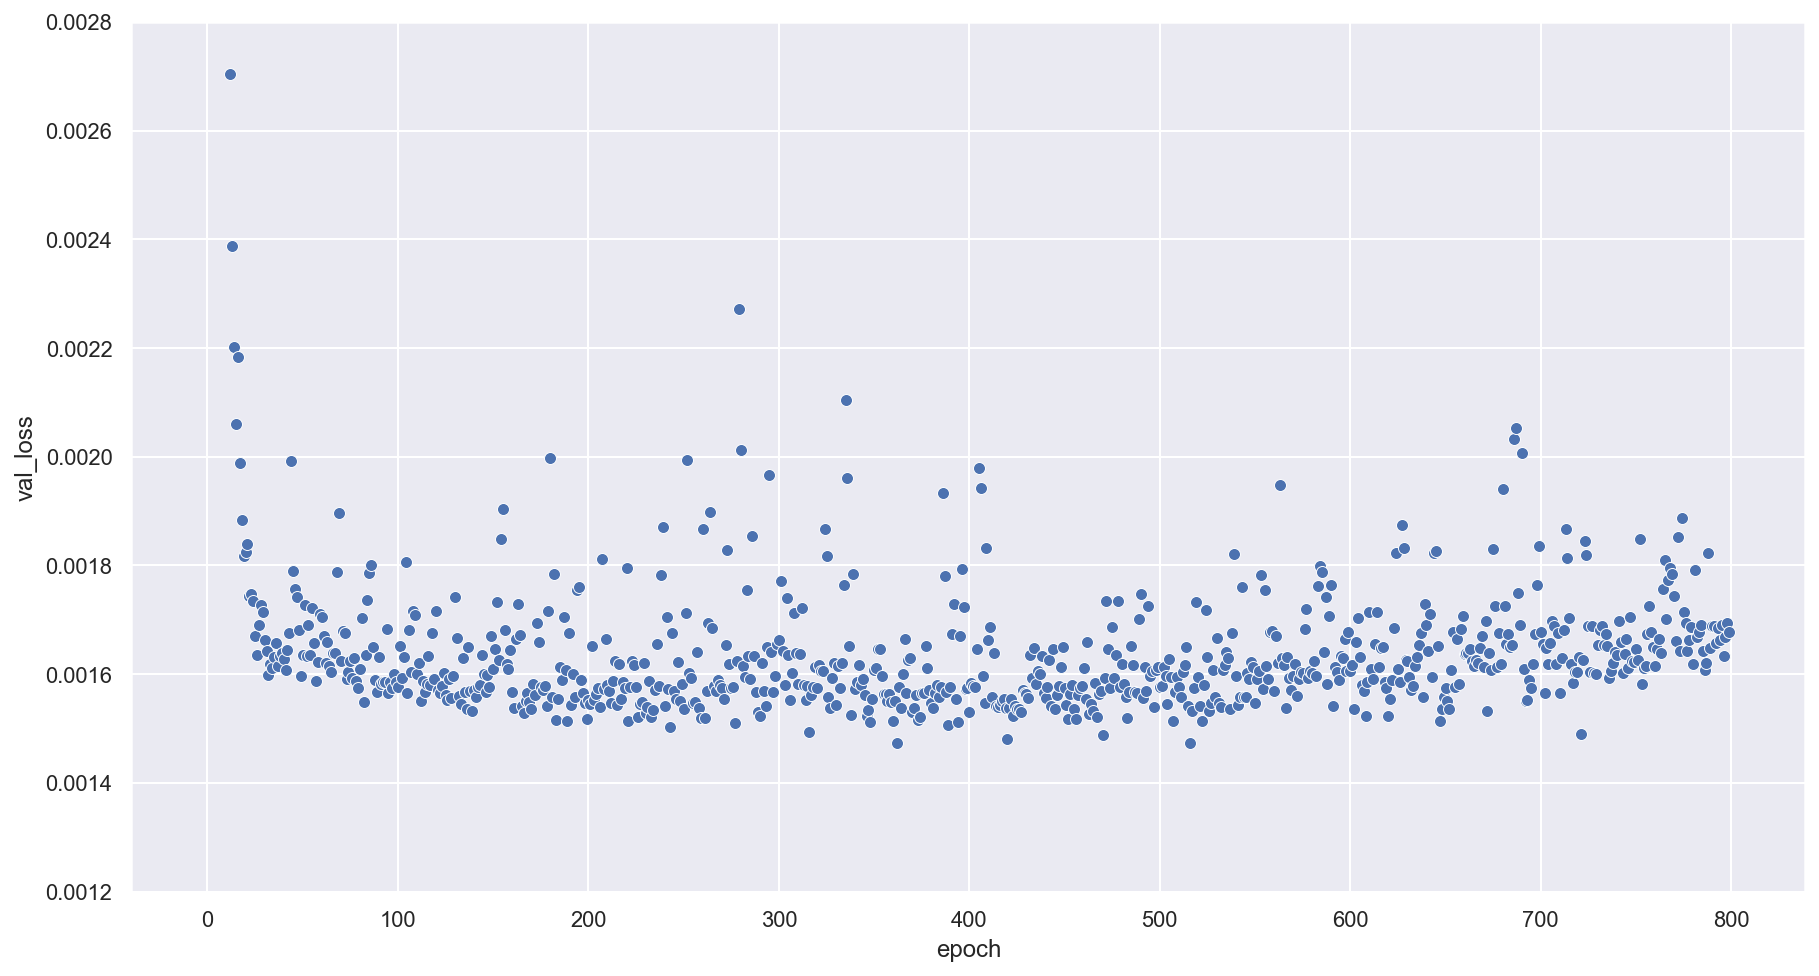

In [193]:
plt.figure(figsize = (15,8))
sns.scatterplot(x=hist['epoch'], y=hist['val_loss']).set_title("Scatterplot of Epoch and validation MSE for 1024 batch size").set(xlabel='Epoch', ylabel='Validation MSE')
plt.show()

plt.figure(figsize = (15,8))
sns.scatterplot(x=hist['epoch'], y=hist['val_loss']).set_title("Scatterplot of Epoch and validation MSE for 1024 batch size - Y axis limited").set(xlabel='Epoch', ylabel='Validation MSE')
plt.ylim(0.0012, 0.0028)
plt.show()

Batch size 32: The epoch value initially falls dramatically from 0 to 50 epochs and appears to plateau at ~ 0.0013 val_MSE at ~ epoch 150. It then begins to bend upwards from 150 onwards, suggesting overfitting is starting to occur.

Batch size 1024: The epoch value initially falls dramatically from 0 to 30 epochs and appears to plateau at ~ 0.0015 val_MSE at ~ epoch 140. From 140 onwards, we observe some higher values for val_MSE, although the majority appear to continue slightly decreasing until around the 450th epoch. From here onwards, the val_MSE clearly creeps upwards.

We have now found the ideal epoch values before val_MSE starts to creep upwards. We could have also used an **early stopping callback function** to prevent overtraining our model.

Another observation is that although the 1024 batch size model trained much faster (which could have implications on minimising computational cost), we achieved an overall lower val_MSE with a batch size of 32.

# Manual hyperparameter tuning conclusions

From the above tests, the following hyperparameters produced the best results for our model:
* Adam optimizer
* relu activation functions for hidden layers
* MSE loss function
* 96 neurons/layer
* 1 x input layer, 3 x hidden layers, 1 x output layer
* batch size: 32
* epochs: 175

We will now create this tuned model and assess its performance with the entire dataset.

In [205]:
def build_tuned_hyper_model():
    model = keras.Sequential([
        layers.Dense(96, activation=tf.nn.relu, input_shape = [len(x_train.keys())]),
        layers.Dense(96, activation=tf.nn.relu),
        layers.Dense(96, activation=tf.nn.relu),
        layers.Dense(96, activation=tf.nn.relu),
        layers.Dense(1, activation="linear")
    ])
    
    optimizer = tf.keras.optimizers.Adam()
    
    model.compile(loss='mse',
                  optimizer=optimizer)
    
    return model

In [206]:
tuned_model = build_tuned_hyper_model()
tuned_model.summary()

Model: "sequential_334"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_1631 (Dense)           (None, 96)                2592      
_________________________________________________________________
dense_1632 (Dense)           (None, 96)                9312      
_________________________________________________________________
dense_1633 (Dense)           (None, 96)                9312      
_________________________________________________________________
dense_1634 (Dense)           (None, 96)                9312      
_________________________________________________________________
dense_1635 (Dense)           (None, 1)                 97        
Total params: 30,625
Trainable params: 30,625
Non-trainable params: 0
_________________________________________________________________


In [207]:
tuned_model_history = tuned_model.fit(x_train, 
                                    y_train, 
                                    epochs=175, 
                                    validation_data=(x_test, y_test),
                                    verbose=0)

Epoch 1/175
135/135 [==============================] - 0s 1ms/step - loss: 0.0142 - val_loss: 0.0027
Epoch 2/175
135/135 [==============================] - 0s 829us/step - loss: 0.0024 - val_loss: 0.0025
Epoch 3/175
135/135 [==============================] - 0s 822us/step - loss: 0.0020 - val_loss: 0.0021
Epoch 4/175
135/135 [==============================] - 0s 837us/step - loss: 0.0018 - val_loss: 0.0024
Epoch 5/175
135/135 [==============================] - 0s 829us/step - loss: 0.0017 - val_loss: 0.0019
Epoch 6/175
135/135 [==============================] - 0s 837us/step - loss: 0.0016 - val_loss: 0.0019
Epoch 7/175
135/135 [==============================] - 0s 964us/step - loss: 0.0014 - val_loss: 0.0018
Epoch 8/175
135/135 [==============================] - 0s 866us/step - loss: 0.0015 - val_loss: 0.0018
Epoch 9/175
135/135 [==============================] - 0s 837us/step - loss: 0.0013 - val_loss: 0.0017
Epoch 10/175
135/135 [==============================] - 0s 844us/step - los

135/135 [==============================] - 0s 829us/step - loss: 5.5543e-04 - val_loss: 0.0014
Epoch 154/175
135/135 [==============================] - 0s 837us/step - loss: 5.1016e-04 - val_loss: 0.0013
Epoch 155/175
135/135 [==============================] - 0s 814us/step - loss: 5.2448e-04 - val_loss: 0.0016
Epoch 156/175
135/135 [==============================] - 0s 814us/step - loss: 5.7681e-04 - val_loss: 0.0013
Epoch 157/175
135/135 [==============================] - 0s 814us/step - loss: 5.0138e-04 - val_loss: 0.0016
Epoch 158/175
135/135 [==============================] - 0s 829us/step - loss: 5.1020e-04 - val_loss: 0.0014
Epoch 159/175
135/135 [==============================] - 0s 814us/step - loss: 5.2451e-04 - val_loss: 0.0014
Epoch 160/175
135/135 [==============================] - 0s 822us/step - loss: 4.9938e-04 - val_loss: 0.0014
Epoch 161/175
135/135 [==============================] - 0s 822us/step - loss: 5.1324e-04 - val_loss: 0.0013
Epoch 162/175
135/135 [==========

In [208]:
tuned_hist = pd.DataFrame(tuned_model_history.history)
tuned_hist['epoch'] = tuned_model_history.epoch

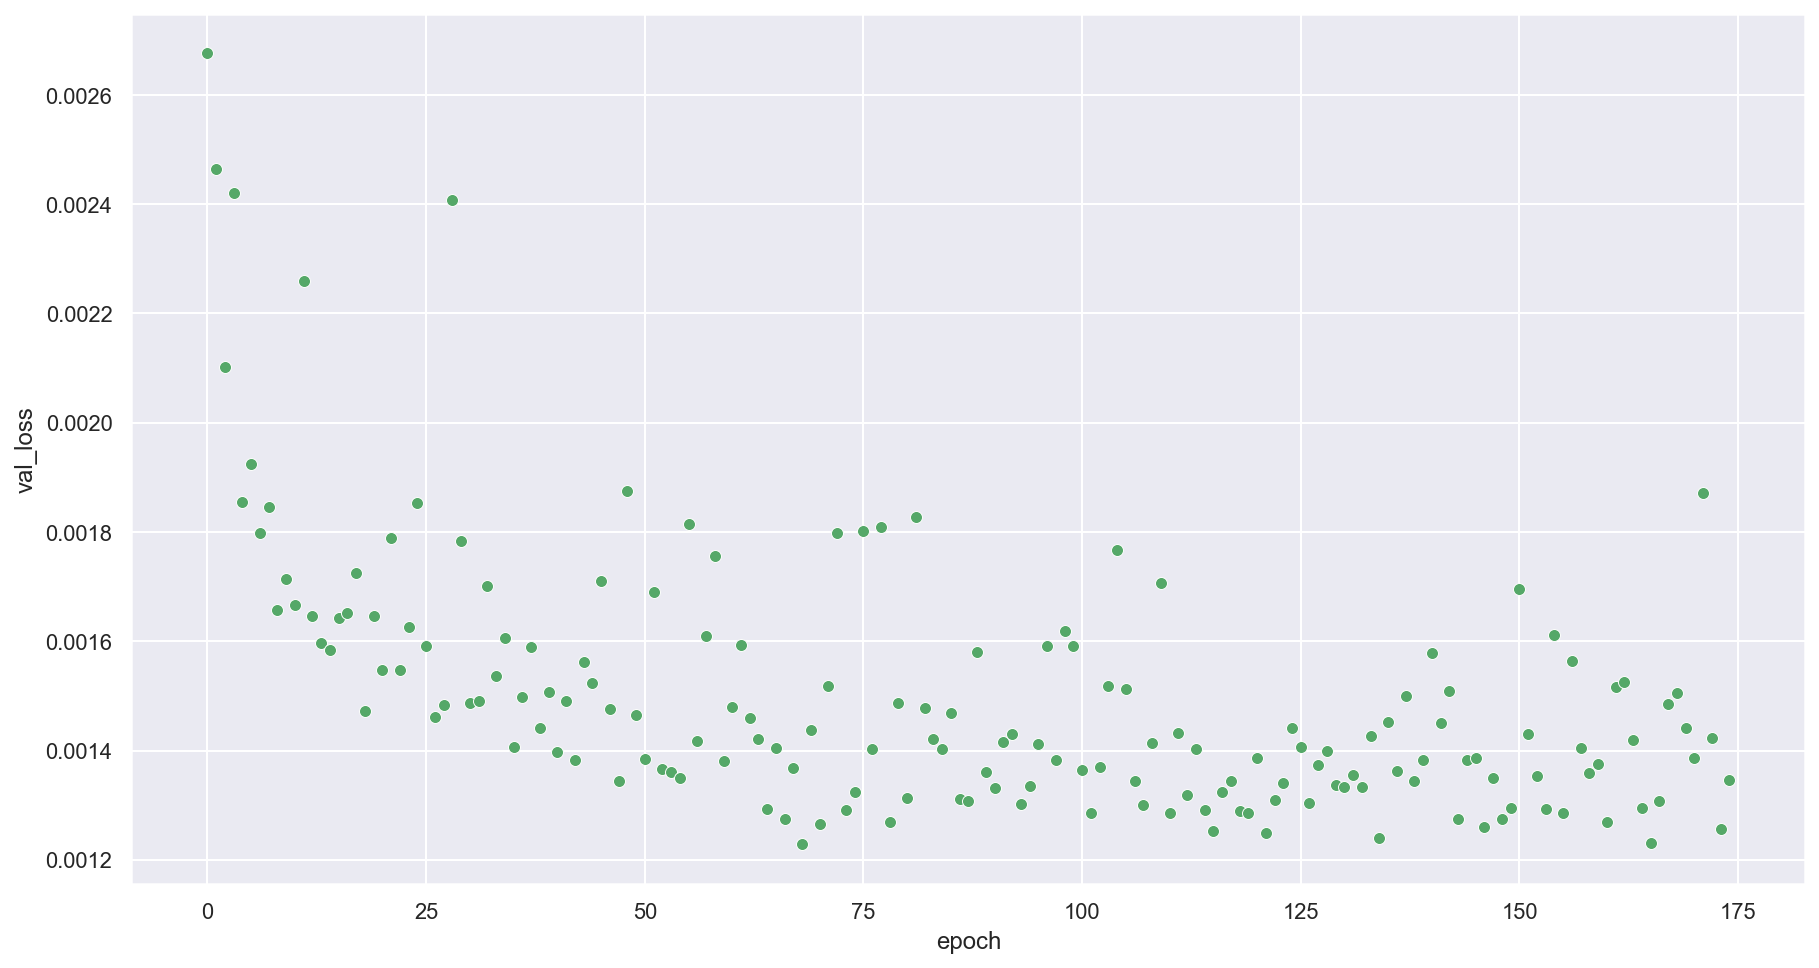

In [209]:
plt.figure(figsize = (15,8))
sns.scatterplot(x=tuned_hist['epoch'], y=tuned_hist['val_loss'], color='g').set_title("Scatterplot of Epoch and validation MSE for tuned model").set(xlabel='Epoch', ylabel='Validation MSE')
plt.show()

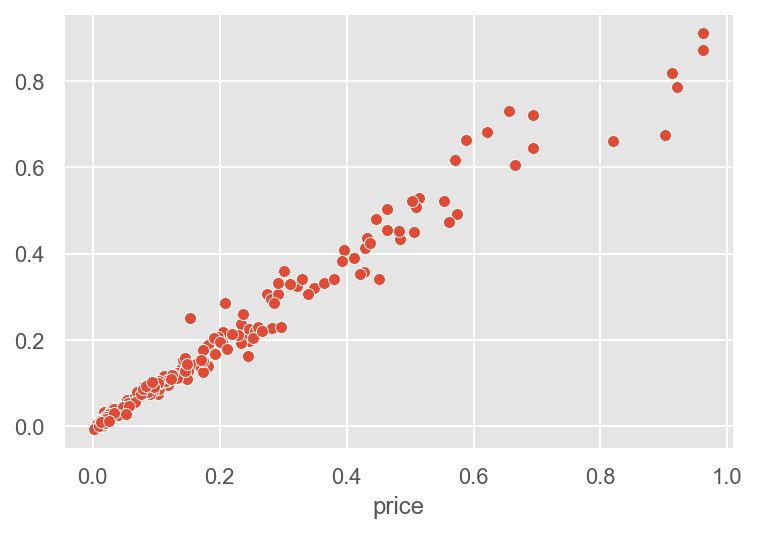

In [213]:
test_predictions = tuned_model.predict(x_test).flatten()

test_predictions_sample = pd.DataFrame(test_predictions).sample(frac=0.2, random_state=0).to_numpy().flatten()
test_target_sample = y_test.sample(frac=0.2, random_state=0)

plt.style.use("ggplot")
sns.scatterplot(x=test_target_sample, y=test_predictions_sample, alpha=0.3).set_title("Scatterplot of Diamond price (test dataset) and predicted diamond price (NN model)").set(xlabel='Diamond price (actual)', ylabel='Diamond price (predicted)')
plt.show()

We are only plotting 20% of the prediction results as this will give us a clearer picture of the density of points and how closely the majority fit to the line of best fit.

We calculate the $R^2$ value below to compare the performance against our multi-linear regression model.

In [220]:
slope, intercept, r_value, p_value, std_err = scipy.stats.linregress(y_test, test_predictions)
print("R_squared:", round(r_value ** 2, 4))

R_squared: 0.97


### Using the entire dataset (compared to only using 10%)

In [222]:
from sklearn.model_selection import train_test_split

full_sample_df = normalized_df.sample(frac=0.99, random_state=0)
x_full = full_sample_df
y_full = x_full.pop("price")

x_train_full, x_test_full, y_train_full, y_test_full = train_test_split(x_full, y_full, test_size=0.2, random_state=0)

In [224]:
full_tuned_model = build_tuned_hyper_model()

In [225]:
full_tuned_model_history = full_tuned_model.fit(x_train_full, 
                                    y_train_full, 
                                    epochs=300, 
                                    validation_data=(x_test_full, y_test_full),
                                    verbose=0)

Epoch 1/300
1335/1335 [==============================] - 1s 801us/step - loss: 0.0030 - val_loss: 0.0015
Epoch 2/300
1335/1335 [==============================] - 1s 724us/step - loss: 0.0015 - val_loss: 0.0017
Epoch 3/300
1335/1335 [==============================] - 1s 726us/step - loss: 0.0014 - val_loss: 0.0014
Epoch 4/300
1335/1335 [==============================] - 1s 730us/step - loss: 0.0013 - val_loss: 0.0012
Epoch 5/300
1335/1335 [==============================] - 1s 735us/step - loss: 0.0012 - val_loss: 0.0011
Epoch 6/300
1335/1335 [==============================] - 1s 732us/step - loss: 0.0012 - val_loss: 0.0014
Epoch 7/300
1335/1335 [==============================] - 1s 740us/step - loss: 0.0012 - val_loss: 0.0012
Epoch 8/300
1335/1335 [==============================] - 1s 740us/step - loss: 0.0011 - val_loss: 0.0016
Epoch 9/300
1335/1335 [==============================] - 1s 744us/step - loss: 0.0011 - val_loss: 0.0011
Epoch 10/300
1335/1335 [==============================]

Epoch 146/300
1335/1335 [==============================] - 1s 754us/step - loss: 7.6594e-04 - val_loss: 9.9228e-04
Epoch 147/300
1335/1335 [==============================] - 1s 742us/step - loss: 7.7436e-04 - val_loss: 9.4539e-04
Epoch 148/300
1335/1335 [==============================] - 1s 743us/step - loss: 7.7195e-04 - val_loss: 8.9735e-04
Epoch 149/300
1335/1335 [==============================] - 1s 723us/step - loss: 7.6437e-04 - val_loss: 9.0693e-04
Epoch 150/300
1335/1335 [==============================] - 1s 719us/step - loss: 7.6556e-04 - val_loss: 9.0486e-04
Epoch 151/300
1335/1335 [==============================] - 1s 724us/step - loss: 7.6911e-04 - val_loss: 8.8759e-04
Epoch 152/300
1335/1335 [==============================] - 1s 720us/step - loss: 7.7537e-04 - val_loss: 0.0010
Epoch 153/300
1335/1335 [==============================] - 1s 722us/step - loss: 7.6230e-04 - val_loss: 9.1617e-04
Epoch 154/300
1335/1335 [==============================] - 1s 723us/step - loss: 7.6

1335/1335 [==============================] - 1s 740us/step - loss: 6.9593e-04 - val_loss: 9.2777e-04
Epoch 289/300
1335/1335 [==============================] - 1s 738us/step - loss: 7.0008e-04 - val_loss: 9.4047e-04
Epoch 290/300
1335/1335 [==============================] - 1s 736us/step - loss: 7.0240e-04 - val_loss: 9.4538e-04
Epoch 291/300
1335/1335 [==============================] - 1s 774us/step - loss: 7.0129e-04 - val_loss: 9.6451e-04
Epoch 292/300
1335/1335 [==============================] - 1s 798us/step - loss: 7.0336e-04 - val_loss: 9.2183e-04
Epoch 293/300
1335/1335 [==============================] - 1s 801us/step - loss: 6.9550e-04 - val_loss: 9.1836e-04
Epoch 294/300
1335/1335 [==============================] - 1s 893us/step - loss: 6.9830e-04 - val_loss: 9.2759e-04
Epoch 295/300
1335/1335 [==============================] - 1s 787us/step - loss: 7.0438e-04 - val_loss: 9.2681e-04
Epoch 296/300
1335/1335 [==============================] - 1s 832us/step - loss: 6.9840e-04 - 

In [226]:
full_tuned_hist = pd.DataFrame(full_tuned_model_history.history)
full_tuned_hist['epoch'] = full_tuned_model_history.epoch

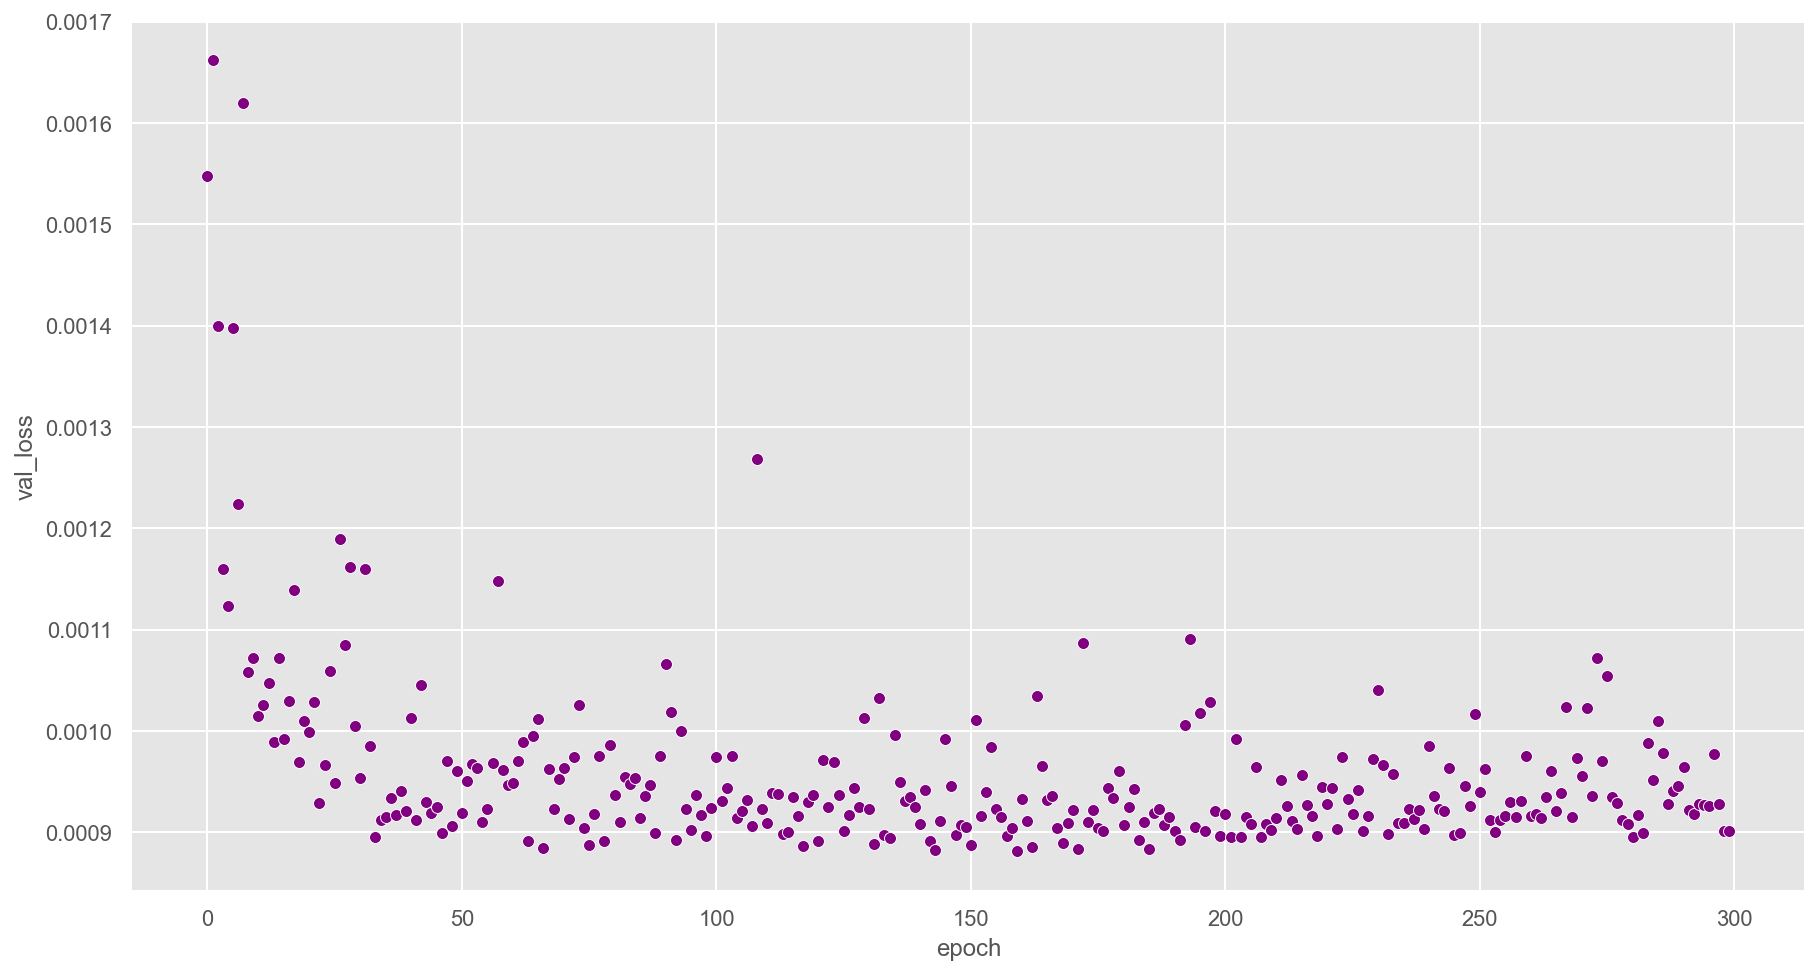

In [228]:
plt.figure(figsize = (15,8))
sns.scatterplot(x=full_tuned_hist['epoch'], y=full_tuned_hist['val_loss'], color='purple').set_title("Scatterplot of Epoch and validation MSE for tuned model").set(xlabel='Epoch', ylabel='Validation MSE')
plt.show()

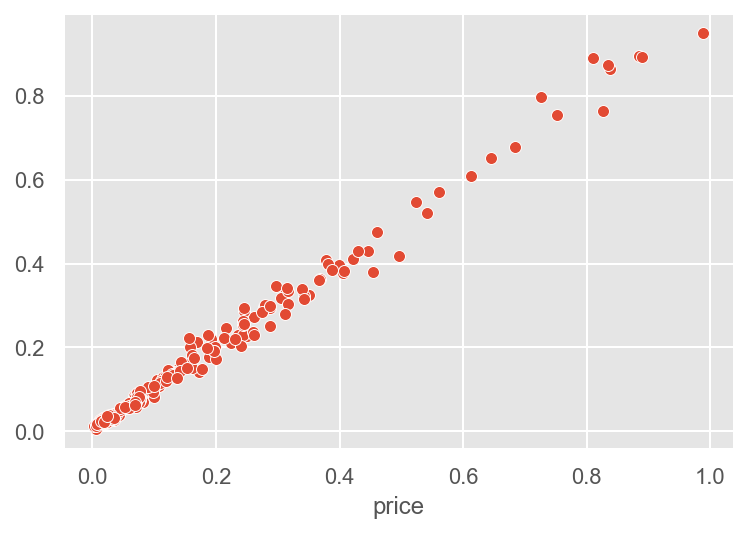

In [235]:
full_test_predictions = full_tuned_model.predict(x_test_full).flatten()

full_test_predictions_sample = pd.DataFrame(full_test_predictions).sample(frac=0.02, random_state=0).to_numpy().flatten()
full_test_target_sample = y_test_full.sample(frac=0.02, random_state=0)

plt.style.use("ggplot")
sns.scatterplot(x=full_test_target_sample, y=full_test_predictions_sample, alpha=0.3).set_title("Scatterplot of Diamond price (test dataset) and predicted diamond price (NN model)").set(xlabel='Diamond price (actual)', ylabel='Diamond price (predicted)')
plt.show()

In [234]:
slope, intercept, r_value, p_value, std_err = scipy.stats.linregress(y_test_full, full_test_predictions)
print("R_squared:", round(r_value ** 2, 4))

R_squared: 0.9805


# Final Discussion & Limitations
Using the full dataset, we managed to achieve a val_MSE of around 0.0009.

As discussed above, a highly significant drawback to our testing method is the inability to test all hyperparameters simultaneously. Using the manual method, we have tuned each hyperparameter sequentially, starting with activation functions, optimizers, network dimensions, batch sizes, then finally, number of epochs.
* This approach has limitations as for example, in order to test activation functions, we had to set static values for the other parameters.
* E.g. we could have been optimising for the best activation function given the prevailing hyperparameter settings.

However, we could not have possibly brute forced all combinations for every single parameter simultaneously within a feasible time frame. We would have had to test $6 \times 5 \times 7 \times 6 \times 10 = 12600$ different models, running over $500$ epochs each (if early stopping was not used).

Despite this, we have managed to achieve an R^2 value of 0.9805 (for predicted vs actual) using manual hyperparameter tuning, which is significantly higher than our multi-linear regression model.

As a note for further tuning options: The bayesian optimization algorithm and Randm Search algorithm attempt to solve this problem by taking random samples of possible hyperparameter combinations and 'intelligently' choosing similar combinations that improve the chosen metric until the improvements plateau. This could help us find a model that performs even better, with a feasible computational cost.